# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv


Якщо не вдається завантажиит з Kaggle, ось тут можна - https://drive.google.com/file/d/1kfu5zCRsDHxoBZigBlGIcCieKlws02HT/view?usp=sharing

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
import pandas as pd

In [2]:
raw_df = pd.read_csv('train-3.csv')
raw_df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [3]:

#Розмірність таблиці
print("- Кількість рядків:", raw_df.shape[0])
print("- Кількість колонок:", raw_df.shape[1])

#Типи даних у кожній колонці
print("\n- Типи даних у колонках:")
print(raw_df.dtypes)

#Кількість пропущених значень
print("\n- Кількість пропущених значень у кожній колонці:")
print(raw_df.isnull().sum())

- Кількість рядків: 27481
- Кількість колонок: 4

- Типи даних у колонках:
textID           object
text             object
selected_text    object
sentiment        object
dtype: object

- Кількість пропущених значень у кожній колонці:
textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [4]:
raw_df = raw_df.dropna(subset=['text','selected_text'])

In [5]:
#Перевірка на кількість пропущених значень після видалення
print("\n- Кількість пропущених значень у кожній колонці:")
print(raw_df.isnull().sum())


- Кількість пропущених значень у кожній колонці:
textID           0
text             0
selected_text    0
sentiment        0
dtype: int64


In [6]:
raw_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [7]:
raw_df['sentiment'].describe()

,sentiment
count,27480
unique,3
top,neutral
freq,11117


In [8]:
raw_df.sentiment.value_counts(normalize=True)

,proportion
sentiment,
neutral,0.404549
positive,0.312300
negative,0.283151


Бачимо, що лідирує в нас клас нейтралів, останній в %-му відношенні - негативні.

In [9]:
raw_df['lenght']= raw_df['selected_text'].astype(str).apply(len)

/tmp/ipython-input-1296963126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['lenght']= raw_df['selected_text'].astype(str).apply(len)


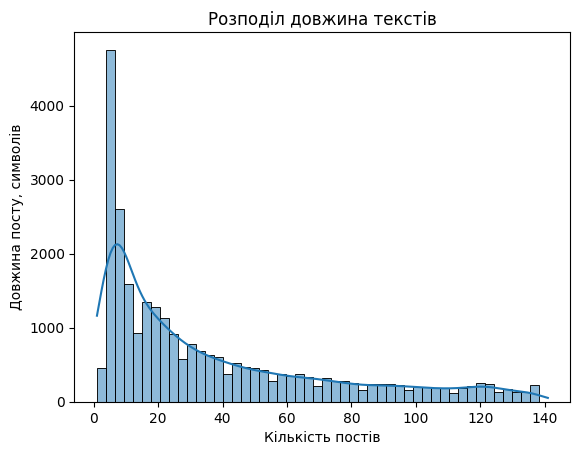

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(raw_df['lenght'], bins=50, kde=True)
plt.title('Розподіл довжина текстів')
plt.xlabel('Кількість постів')
plt.ylabel('Довжина посту, символів')
plt.show()

З цього розподілу можна спостерігати, що найбільша довжина тексту була >4000 (символів), але к-ть постів при цьому одна з найменших. Щось з виду "рідко, але мітко" :)

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [11]:
import re
# очищення колонки "text" від ком? крапок та іншого "сміття"
raw_df["clean_text"] = raw_df["text"].apply(lambda x: re.sub(r"[^a-zA-Z\s]", "", x))

/tmp/ipython-input-413731622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df["clean_text"] = raw_df["text"].apply(lambda x: re.sub(r"[^a-zA-Z\s]", "", x))


Далі переходжу до токенізації

In [12]:
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize

In [13]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [14]:
raw_df["tokens"] = raw_df["clean_text"].apply(lambda x: word_tokenize(x.lower()))

/tmp/ipython-input-1664816233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df["tokens"] = raw_df["clean_text"].apply(lambda x: word_tokenize(x.lower()))


In [15]:
raw_df

,textID,text,selected_text,sentiment,lenght,clean_text,tokens
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,35,Id have responded if I were going,"[id, have, responded, if, i, were, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,8,Sooo SAD I will miss you here in San Diego,"[sooo, sad, i, will, miss, you, here, in, san,..."
2,088c60f138,my boss is bullying me...,bullying me,negative,11,my boss is bullying me,"[my, boss, is, bullying, me]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,14,what interview leave me alone,"[what, interview, leave, me, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,13,Sons of why couldnt they put them on the rel...,"[sons, of, why, couldnt, they, put, them, on, ..."
...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,6,wish we could come see u on Denver husband l...,"[wish, we, could, come, see, u, on, denver, hu..."
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,13,Ive wondered about rake to The client has ma...,"[ive, wondered, about, rake, to, the, client, ..."
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,25,Yay good for both of you Enjoy the break you...,"[yay, good, for, both, of, you, enjoy, the, br..."
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,26,But it was worth it,"[but, it, was, worth, it]"


Стемлін

In [16]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language='english')

In [17]:
raw_df["stemmer"] = raw_df["tokens"].apply(lambda tokens:[stemmer.stem(word) for word in tokens])

/tmp/ipython-input-3912324241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df["stemmer"] = raw_df["tokens"].apply(lambda tokens:[stemmer.stem(word) for word in tokens])


In [18]:
raw_df

,textID,text,selected_text,sentiment,lenght,clean_text,tokens,stemmer
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,35,Id have responded if I were going,"[id, have, responded, if, i, were, going]","[id, have, respond, if, i, were, go]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,8,Sooo SAD I will miss you here in San Diego,"[sooo, sad, i, will, miss, you, here, in, san,...","[sooo, sad, i, will, miss, you, here, in, san,..."
2,088c60f138,my boss is bullying me...,bullying me,negative,11,my boss is bullying me,"[my, boss, is, bullying, me]","[my, boss, is, bulli, me]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,14,what interview leave me alone,"[what, interview, leave, me, alone]","[what, interview, leav, me, alon]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,13,Sons of why couldnt they put them on the rel...,"[sons, of, why, couldnt, they, put, them, on, ...","[son, of, whi, couldnt, they, put, them, on, t..."
...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,6,wish we could come see u on Denver husband l...,"[wish, we, could, come, see, u, on, denver, hu...","[wish, we, could, come, see, u, on, denver, hu..."
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,13,Ive wondered about rake to The client has ma...,"[ive, wondered, about, rake, to, the, client, ...","[ive, wonder, about, rake, to, the, client, ha..."
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,25,Yay good for both of you Enjoy the break you...,"[yay, good, for, both, of, you, enjoy, the, br...","[yay, good, for, both, of, you, enjoy, the, br..."
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,26,But it was worth it,"[but, it, was, worth, it]","[but, it, was, worth, it]"


Вже після токенізації та стемлінгу я переходжу до видалення стоп-слів
Взагалі я планувала видалення стоп-слів ставити другим в порядку обробки, але стемлінг працював не правильно

In [19]:
nltk.download('stopwords')
english_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
raw_df["stopww"] = raw_df["stemmer"].apply(
    lambda stemmer: " ".join(
        [word for word in stemmer if word.lower() not in english_stopwords]
    )
)

/tmp/ipython-input-3958513650.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df["stopww"] = raw_df["stemmer"].apply(


In [21]:
raw_df

,textID,text,selected_text,sentiment,lenght,clean_text,tokens,stemmer,stopww
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,35,Id have responded if I were going,"[id, have, responded, if, i, were, going]","[id, have, respond, if, i, were, go]",id respond go
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,8,Sooo SAD I will miss you here in San Diego,"[sooo, sad, i, will, miss, you, here, in, san,...","[sooo, sad, i, will, miss, you, here, in, san,...",sooo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,11,my boss is bullying me,"[my, boss, is, bullying, me]","[my, boss, is, bulli, me]",boss bulli
3,9642c003ef,what interview! leave me alone,leave me alone,negative,14,what interview leave me alone,"[what, interview, leave, me, alone]","[what, interview, leav, me, alon]",interview leav alon
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,13,Sons of why couldnt they put them on the rel...,"[sons, of, why, couldnt, they, put, them, on, ...","[son, of, whi, couldnt, they, put, them, on, t...",son whi couldnt put releas alreadi bought
...,...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,6,wish we could come see u on Denver husband l...,"[wish, we, could, come, see, u, on, denver, hu...","[wish, we, could, come, see, u, on, denver, hu...",wish could come see u denver husband lost job ...
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,13,Ive wondered about rake to The client has ma...,"[ive, wondered, about, rake, to, the, client, ...","[ive, wonder, about, rake, to, the, client, ha...",ive wonder rake client made clear net onli don...
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,25,Yay good for both of you Enjoy the break you...,"[yay, good, for, both, of, you, enjoy, the, br...","[yay, good, for, both, of, you, enjoy, the, br...",yay good enjoy break probabl need hectic weeke...
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,26,But it was worth it,"[but, it, was, worth, it]","[but, it, was, worth, it]",worth


sklearn.feature_extraction.text.CountVectorizer

Загалом мета CountVectorizer це перетворення текстових даних на матрицю, в якій ми можемо бачити частоту використання слів

In [22]:
raw_df.text.values

array([' I`d have responded, if I were going',
       ' Sooo SAD I will miss you here in San Diego!!!',
       'my boss is bullying me...', ...,
       ' Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend  Take care hun xxxx',
       ' But it was worth it  ****.',
       '   All this flirting going on - The ATG smiles. Yay.  ((hugs))'],
      dtype=object)

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
vector = CountVectorizer()
vector_fit= vector.fit_transform(raw_df.text)

In [25]:
vector.get_feature_names_out()[10000:10010]

array(['forgotten', 'forgottten', 'fork', 'forked', 'form', 'formal',
       'formally', 'format', 'former', 'formidable'], dtype=object)

In [26]:
vector.get_feature_names_out()[:10]

array(['00', '000', '000th', '00am', '00pm', '01', '02', '024', '02mxjj',
       '03'], dtype=object)

In [27]:
stemmer = SnowballStemmer(language='english')

In [28]:
def tokenize(text):
    return [stemmer.stem(word) for word in word_tokenize(text)]

In [29]:
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=english_stopwords,
                             max_features=1000)

In [30]:
%%time
vectorizer.fit(raw_df.text)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CPU times: user 4.38 s, sys: 7.94 ms, total: 4.38 s
Wall time: 4.39 s


CountVectorizer(max_features=1000,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...],
                tokenizer=<function tokenize at 0x7d5d56ba1d00>)

In [31]:
len(vectorizer.vocabulary_)

1000

In [32]:
vectorizer.get_feature_names_out()[:100]

array(['!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '--',
       '.', '..', '...', '....', '.....', '......', '.......', '/', '1',
       '10', '100', '11', '12', '15', '1st', '2', '20', '2day', '2nd',
       '3', '30', '4', '4th', '5', '6', '7', '8', ':', ';', '<', '=', '>',
       '?', '@', '[', ']', '_', '`', 'abl', 'absolut', 'account', 'ach',
       'actual', 'ad', 'add', 'addict', 'afternoon', 'age', 'ago', 'agre',
       'ah', 'ahh', 'ahhh', 'aint', 'air', 'airport', 'album', 'almost',
       'alon', 'along', 'alot', 'alreadi', 'alright', 'also', 'although',
       'alway', 'amaz', 'american', 'ani', 'anim', 'annoy', 'anoth',
       'answer', 'anymor', 'anyon', 'anyth', 'anytim', 'anyway', 'apart',
       'app', 'appar', 'appl', 'appreci', 'arm', 'around', 'arriv', 'art'],
      dtype=object)

In [33]:
%%time
inputs = vectorizer.transform(raw_df.text)

CPU times: user 4.82 s, sys: 1.82 ms, total: 4.82 s
Wall time: 4.85 s


In [34]:
inputs.shape

(27480, 1000)

In [35]:
inputs[:10]

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 40 stored elements and shape (10, 1000)>

In [36]:
raw_df.text.values[0]

' I`d have responded, if I were going'

In [37]:
inputs[0].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [79]:
#так як мій таргет це колонка sentiment - текстова, тому для роботи з логістичною регресією треба числові значення - рішення закодувати.
le = LabelEncoder()
y = le.fit_transform(raw_df['sentiment'])

In [63]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    raw_df['text'], y, test_size=0.2, random_state=42, stratify=y
)

In [64]:
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=english_stopwords,
                             max_features=10000)

X_train_bow = vectorizer.fit_transform(X_train_bow)
X_test_bow = vectorizer.transform(X_test_bow)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


In [65]:
X_train_bow.shape, X_test_bow.shape, y_train.shape, y_test.shape

((21984, 10000), (5496, 10000), (21984,), (5496,))

Logistic Regression

In [66]:
MAX_ITER = 1000

In [80]:
lr = LogisticRegression(max_iter=MAX_ITER, solver='sag')

In [81]:
%%time
lr.fit(X_train_bow, y_train)

CPU times: user 8.46 s, sys: 3.99 ms, total: 8.47 s
Wall time: 8.47 s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, solver='sag')

In [82]:
train_preds = lr.predict(X_train_bow)

In [83]:
pd.Series(train_preds).value_counts(normalize=True)

,proportion
1,0.447871
2,0.297944
0,0.254185


In [84]:
pd.Series(train_preds).value_counts()

,count
1,9846
2,6550
0,5588


In [85]:
pd.Series(y_train).value_counts()

,count
1,8894
2,6865
0,6225


In [86]:
test_preds = lr.predict(X_test_bow)

In [87]:
pd.Series(test_preds).value_counts(normalize=True)

,proportion
1,0.463610
2,0.284753
0,0.251638


In [88]:
pd.Series(test_preds).value_counts()

,count
1,2548
2,1565
0,1383


In [89]:
print(f"Train: Accuracy: {accuracy_score(y_train, train_preds):.4f},"
      f"F1: {f1_score(y_train, train_preds, average='weighted'):.4f}")
print(f"Test: Accuracy: {accuracy_score(y_test, test_preds):.4f},"
      f"F1: {f1_score(y_test, test_preds, average='weighted'):.4f}")

Train: Accuracy: 0.8210,F1: 0.8210
Test: Accuracy: 0.6961,F1: 0.6968


### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [78]:
type(lr)


sklearn.preprocessing._label.LabelEncoder

In [93]:
#Топ-10 найбільш впливових слів (LogisticRegression)
for i, label in enumerate(lr.classes_):
    print(f"\n Топ-10 важливих слів для класу {label}")
    feature_importance = pd.Series(
        lr.coef_[i],
        index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)
    print(" + Позитивні:", feature_importance.head(10).to_dict())
    print(" - Негативні:", feature_importance.tail(10).to_dict())


 Топ-10 важливих слів для класу 0
 + Позитивні: {'sad': 2.526346307727818, 'suck': 2.308394882736953, 'sorri': 2.2311985655372384, 'bore': 2.2025214847702865, 'hate': 2.128916292545073, 'fail': 2.0515311516901584, 'miss': 1.9842589822381744, 'stupid': 1.937594207340537, 'headach': 1.854448871163715, 'hurt': 1.7734781652061296}
 - Негативні: {'great': -1.4121329747104323, 'enjoy': -1.5204792483061869, 'amaz': -1.5235025357756806, 'welcom': -1.5681870071352302, 'cute': -1.6511855285992316, 'beauti': -1.7172846825095949, 'thank': -1.974947100648353, 'love': -2.0317459686218067, 'glad': -2.1112300099132546, 'awesom': -2.2106029271218683}

 Топ-10 важливих слів для класу 1
 + Позитивні: {'indoor': 0.9327731282588234, 'otherwis': 0.9264830458675842, 'guitar': 0.8219691740020427, 'grade': 0.7988581016835855, 'except': 0.7983829585223366, 'starwarsday': 0.7744341787663074, 'parvo': 0.7622523728978154, '2moro': 0.7442733308643834, 'jst': 0.7297202069425825, 'mmm': 0.724866998428865}
 - Негатив

Загалом, мене влаштовують результати емоційного забарвлення та той ТОП-10 який виведенний на екран.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [95]:
raw_df_2 = pd.read_csv('train-3.csv')
raw_df_2

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [96]:
raw_df_2 = raw_df_2.dropna(subset=['text','selected_text'])

In [97]:
# очищення колонки "text" від ком? крапок та іншого "сміття"
raw_df_2["clean_text"] = raw_df_2["text"].apply(lambda x: re.sub(r"[^a-zA-Z\s]", "", x))

/tmp/ipython-input-2747771163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df_2["clean_text"] = raw_df_2["text"].apply(lambda x: re.sub(r"[^a-zA-Z\s]", "", x))


In [133]:
raw_df_2["clean_text"] = raw_df_2["clean_text"].apply(lambda x: re.sub(r'<.*?>+', "", x))

/tmp/ipython-input-3819432585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df_2["clean_text"] = raw_df_2["clean_text"].apply(lambda x: re.sub(r'<.*?>+', "", x))


In [134]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [135]:
raw_df_2["tokens"] = raw_df_2["clean_text"].apply(lambda x: word_tokenize(x.lower()))

/tmp/ipython-input-2807263135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df_2["tokens"] = raw_df_2["clean_text"].apply(lambda x: word_tokenize(x.lower()))


In [136]:
stemmer = SnowballStemmer(language='english')

In [137]:
raw_df_2["stemmer"] = raw_df_2["tokens"].apply(lambda tokens:[stemmer.stem(word) for word in tokens])

/tmp/ipython-input-1610475041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df_2["stemmer"] = raw_df_2["tokens"].apply(lambda tokens:[stemmer.stem(word) for word in tokens])


In [138]:
nltk.download('stopwords')
english_stopwords = stopwords.words('english')

raw_df_2["stopww"] = raw_df_2["stemmer"].apply(
    lambda stemmer: " ".join(
        [word for word in stemmer if word.lower() not in english_stopwords]
    )
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipython-input-2697583364.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df_2["stopww"] = raw_df_2["stemmer"].apply(


In [139]:
raw_df_2.text.values

array([' I`d have responded, if I were going',
       ' Sooo SAD I will miss you here in San Diego!!!',
       'my boss is bullying me...', ...,
       ' Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend  Take care hun xxxx',
       ' But it was worth it  ****.',
       '   All this flirting going on - The ATG smiles. Yay.  ((hugs))'],
      dtype=object)

In [140]:
vector = CountVectorizer()
vector_fit= vector.fit_transform(raw_df_2.text)

In [141]:
vector.get_feature_names_out()[10000:10010]

array(['forgotten', 'forgottten', 'fork', 'forked', 'form', 'formal',
       'formally', 'format', 'former', 'formidable'], dtype=object)

In [142]:
vector.get_feature_names_out()[:10]

array(['00', '000', '000th', '00am', '00pm', '01', '02', '024', '02mxjj',
       '03'], dtype=object)

In [143]:
stemmer = SnowballStemmer(language='english')

In [144]:
def tokenize(text):
    return [stemmer.stem(word) for word in word_tokenize(text)]

In [145]:
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=english_stopwords,
                             max_features=1000)

In [146]:
%%time
vectorizer.fit(raw_df_2.text)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CPU times: user 4.94 s, sys: 7.84 ms, total: 4.95 s
Wall time: 4.98 s


CountVectorizer(max_features=1000,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...],
                tokenizer=<function tokenize at 0x7d5d529c0ea0>)

In [147]:
%%time
inputs = vectorizer.transform(raw_df_2.text)

CPU times: user 4.28 s, sys: 990 µs, total: 4.28 s
Wall time: 4.28 s


Логістична регресія

In [148]:
#так як мій таргет це колонка sentiment - текстова, тому для роботи з логістичною регресією треба числові значення - рішення закодувати.
le = LabelEncoder()
y = le.fit_transform(raw_df_2['sentiment'])

In [149]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    raw_df_2['text'], y, test_size=0.2, random_state=42, stratify=y
)

In [150]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [151]:
# Векторизація TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    stop_words=english_stopwords,
    lowercase=True,
    max_features=10000
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_bow)
X_test_tfidf = tfidf_vectorizer.transform(X_test_bow)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


In [152]:
# Logistic Regression
lr_tfidf = LogisticRegression(solver='sag', max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)
y_train_pred_lr_tfidf = lr_tfidf.predict(X_train_tfidf)
y_test_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)

In [153]:
print(f"Train: Accuracy: {accuracy_score(y_train, y_train_pred_lr_tfidf):.4f},"
      f"F1: {f1_score(y_train, y_train_pred_lr_tfidf, average='weighted'):.4f}")
print(f"Test: Accuracy: {accuracy_score(y_test, y_test_pred_lr_tfidf):.4f},"
      f"F1: {f1_score(y_test, y_test_pred_lr_tfidf, average='weighted'):.4f}")

Train: Accuracy: 0.7932,F1: 0.7933
Test: Accuracy: 0.6858,F1: 0.6865


In [154]:
# Дані з попередніх експериментів BoW
bow_results = pd.DataFrame({
    ('LogisticRegression BoW', 'Train'): {'Accuracy': 0.8210, 'F1': 0.8210},
    ('LogisticRegression BoW', 'Test'): {'Accuracy': 0.6961, 'F1': 0.6968},
}).T

# Актуальні результати TF-IDF
tfidf_results = pd.DataFrame({
    ('LogisticRegression TF-IDF', 'Train'): {'Accuracy': 0.7932, 'F1': 0.7933},
    ('LogisticRegression TF-IDF', 'Test'): {'Accuracy': 0.6858, 'F1': 0.6865},
}).T

comparison_df = pd.concat([bow_results, tfidf_results])
comparison_df.index.names = ['Model', 'Dataset']
comparison_df

Accuracy      F1
Model                     Dataset                  
LogisticRegression BoW    Train      0.8210  0.8210
                          Test       0.6961  0.6968
LogisticRegression TF-IDF Train      0.7932  0.7933
                          Test       0.6858  0.6865

За результатами порівняння отриманих данних, бачимо що TF-IDF не покращив результати на трейні, на тесті наблизився до результатів BoW

In [155]:
features = tfidf_vectorizer.get_feature_names_out()

# Ваги (коефіцієнти) моделі по кожному класу
coefs = lr_tfidf.coef_

# Зберемо важливі слова для кожного класу
top_tokens_per_class = {}
for i, class_label in enumerate(le.classes_):
    top_tokens = pd.Series(coefs[i], index=features).sort_values(ascending=False)
    top_tokens_per_class[class_label] = top_tokens.head(10)

top_tokens_df_tfidf = pd.DataFrame(top_tokens_per_class).T
top_tokens_df_tfidf


,2moro,?,amaz,awesom,bore,differ,enjoy,except,fail,goin,...,miss,nice,otherwis,poor,sad,sorri,stupid,suck,thank,tho
negative,NaN,NaN,NaN,NaN,4.135593,NaN,NaN,NaN,3.862828,NaN,...,5.448814,NaN,NaN,3.398372,5.686788,4.881944,3.550978,4.529057,NaN,NaN
neutral,0.979933,1.184489,NaN,NaN,NaN,1.115388,NaN,1.311782,NaN,1.007174,...,NaN,NaN,0.968072,NaN,NaN,NaN,NaN,NaN,NaN,1.062832
positive,NaN,NaN,4.124217,5.109947,NaN,NaN,4.001534,NaN,NaN,NaN,...,NaN,4.542276,NaN,NaN,NaN,NaN,NaN,NaN,6.215249,NaN


По цій таблиці бачимо, які емоційні класи в нас зустрічаються, як позитивно забарвлені так і негативно. Також бачу "?"...проліз якось...
TF-IDF матриця відображає вагу кожного слова: чим вище значення, тим важливішим є слово для певного документа і тим рідше воно трапляється в інших. Такий підхід допомагає визначити, які слова справді мають значення для змісту кожного документа.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [157]:
# Logistic Regression
lr_tfidf = LogisticRegression(solver='sag', max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)
y_train_pred_lr_tfidf = lr_tfidf.predict(X_train_tfidf)
y_test_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)


# Аналіз помилок
errors_df = pd.DataFrame({
    'text': X_test_bow,
    'true': le.inverse_transform(y_test),
    'predicted': le.inverse_transform(y_test_pred_lr_tfidf)
})

# Хибні передбачення
errors_df = errors_df[errors_df['true'] != errors_df['predicted']]
errors_df.head(20)

,text,true,predicted
23414,Reading and taking notes but undertanding none...,negative,neutral
24609,wow this morning 8.15 hrs ding dong breakfasts...,positive,neutral
4127,Hoping that this will just heal on it`s own be...,neutral,negative
4832,yum. Do you do home delivery,positive,neutral
19360,Having a wonderful piece of cake for lunch - w...,positive,neutral
24967,"Don`t worry, you`ll get your stamina back soo...",positive,neutral
10652,shack idol today(: can`t wait. it`s gonna be f...,neutral,negative
17484,"Awww, *hugs* I wish I could help.",negative,positive
7936,2 hours after teleconference. but can`t go bac...,negative,neutral
10247,Youtube isn`t working...and I wanted to watch ...,negative,neutral


Після аналізу помилкових класифікацій видно, що модель Logistic Regression найчастіше плутає позитивні та негативні висловлювання з нейтральними. Це свідчить про складність розмежування емоційно слабко виражених повідомлень. Часто позитивні фрази без явних маркерів (“love”, “great”, “amazing”) сприймаються як нейтральні, а м’яко негативні — також потрапляють до цього класу. Такі помилки можуть бути зумовлені тим, що TF-IDF не враховує порядок слів і контекст, через що вирази типу “not happy” чи “so bad” не завжди правильно інтерпретуються. Крім того, короткі тексти та неоднозначні вислови ускладнюють визначення емоційного забарвлення.

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model